### Deep Neural Network For Classification - Python Implementation

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

#### General steps to build neural network:
1. Define the neural network structure ( # of input units,  # of hidden units, etc)
2. Initialize the model's parameters
3. Loop:
    - Implement forward propagation
    - Compute loss
    - Implement backward propagation to get the gradients
    - Update parameters


In [2]:
def weights_init(layer_dims,init_type='he_normal',seed=0):

    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
                  layer_dims lis is like  [ no of input features,# of neurons in hidden layer-1,..,
                                     # of neurons in hidden layer-n shape,output]
    init_type -- he_normal  --> N(0,sqrt(2/fanin))
                 he_uniform --> Uniform(-sqrt(6/fanin),sqrt(6/fanin))
                 xavier_normal --> N(0,2/(fanin+fanout))
                 xavier_uniform --> Uniform(-sqrt(6/fanin+fanout),sqrt(6/fanin+fanout))
    seed -- random seed to generate weights
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    np.random.seed(seed)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network
    if  init_type == 'he_normal':
        for l in range(1, L):
            parameters['W' + str(l)] = np.random.normal(0,np.sqrt(2.0/layer_dims[l-1]),(layer_dims[l], layer_dims[l-1]))
            parameters['b' + str(l)] = np.random.normal(0,np.sqrt(2.0/layer_dims[l-1]),(layer_dims[l], 1))  
            
    elif init_type == 'he_uniform':
        for l in range(1, L):
            parameters['W' + str(l)] = np.random.uniform(-np.sqrt(6.0/layer_dims[l-1]),
                                                        np.sqrt(6.0/layer_dims[l-1]),
                                                        (layer_dims[l], layer_dims[l-1]))
            parameters['b' + str(l)] = np.random.uniform(-np.sqrt(6.0/layer_dims[l-1]),
                                                        np.sqrt(6.0/layer_dims[l-1]),
                                                        (layer_dims[l], 1))
            
    elif init_type == 'xavier_normal':
        for l in range(1, L):
            parameters['W' + str(l)] = np.random.normal(0,2.0/(layer_dims[l]+layer_dims[l-1]),(layer_dims[l], layer_dims[l-1]))
            parameters['b' + str(l)] = np.random.normal(0,2.0/(layer_dims[l]+layer_dims[l-1]),(layer_dims[l], 1)) 
            
    elif init_type == 'xavier_uniform':
        for l in range(1, L):
            parameters['W' + str(l)] = np.random.uniform(-(np.sqrt(6.0/(layer_dims[l]+layer_dims[l-1]))),
                                                        (np.sqrt(6.0/(layer_dims[l]+layer_dims[l-1]))),
                                                        (layer_dims[l], layer_dims[l-1]))
            parameters['b' + str(l)] = np.random.uniform(-(np.sqrt(6.0/(layer_dims[l]+layer_dims[l-1]))),
                                                        (np.sqrt(6.0/(layer_dims[l]+layer_dims[l-1]))),
                                                        (layer_dims[l], 1))
            
    return parameters

In [3]:
def sigmoid(X,derivative=False):
    '''Compute Sigmaoid and its derivative'''
    if derivative == False:
        out = 1 / (1 + np.exp(-np.array(X)))
    elif derivative == True:
        s = 1 / (1 + np.exp(-np.array(X)))
        out = s*(1-s)
    return out
def ReLU(X,alpha=0,derivative=False):
    '''Compute ReLU function and derivative'''
    X = np.array(X,dtype=np.float64)
    if derivative == False:
        return np.where(X<0,alpha*X,X)
    elif derivative == True:
        X_relu = np.ones_like(X,dtype=np.float64)
        X_relu[X < 0] = alpha
        return X_relu
def Tanh(X,derivative=False):
    '''Compute tanh values and derivative of tanh'''
    if derivative == False:
        return np.tanh(X)
    if derivative == True:
        return 1 - (np.tanh(X))**2
def softplus(X,derivative=False):
    '''Compute tanh values and derivative of tanh'''
    if derivative == False:
        return np.log(1+np.exp(X))
    if derivative == True:
        return 1 / (1 + np.exp(-np.array(X)))
    
def arctan(X,derivative=False):
    '''Compute tan^-1(X) and derivative'''
    if derivative == False:
        return  np.arctan(X)
    if derivative == True:
        return 1/ (1 + np.square(X))

def identity(X,derivative=False):
    '''identity function and derivative f(x) = x'''
    X = np.array(X)
    if derivative ==  False:
        return X
    if derivative == True:
        return np.ones_like(X)
def elu(X,alpha=0,derivative=False):
    '''Exponential Linear Unit'''
    X = np.array(X,dtype=np.float64)
    if derivative == False:
        return np.where(X<0,alpha*(np.exp(X)-1),X)
    elif derivative == True:
        return np.where(X<0,alpha*(np.exp(X)),1)
    
def softmax(X):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(X) / np.sum(np.exp(X),axis=0)
    

In [6]:
def weights_init(layer_dims,init_type='he_normal',seed=None):
        
        """
        Arguments:
            layer_dims -- python array (list) containing the dimensions of each layer in our network
            layer_dims lis is like  [ no of input features,# of neurons in hidden layer-1,..,
                                     # of neurons in hidden layer-n shape,output]
            init_type -- he_normal  --> N(0,sqrt(2/fanin))
                         he_uniform --> Uniform(-sqrt(6/fanin),sqrt(6/fanin))
                         xavier_normal --> N(0,2/(fanin+fanout))
                         xavier_uniform --> Uniform(-sqrt(6/fanin+fanout),sqrt(6/fanin+fanout))
                         seed -- random seed to generate weights
        Returns:
            parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
        """
        np.random.seed(seed)
        parameters = {}
        opt_parameters = {}
        L = len(layer_dims)            # number of layers in the network
        if  init_type == 'he_normal':
            for l in range(1, L):
                parameters['W' + str(l)] = np.random.normal(0,np.sqrt(2.0/layer_dims[l-1]),(layer_dims[l], layer_dims[l-1]))
                parameters['b' + str(l)] = np.random.normal(0,np.sqrt(2.0/layer_dims[l-1]),(layer_dims[l], 1))  
            
        elif init_type == 'he_uniform':
            for l in range(1, L):
                parameters['W' + str(l)] = np.random.uniform(-np.sqrt(6.0/layer_dims[l-1]),
                                                        np.sqrt(6.0/layer_dims[l-1]),
                                                        (layer_dims[l], layer_dims[l-1]))
                parameters['b' + str(l)] = np.random.uniform(-np.sqrt(6.0/layer_dims[l-1]),
                                                        np.sqrt(6.0/layer_dims[l-1]),
                                                        (layer_dims[l], 1))
            
        elif init_type == 'xavier_normal':
            for l in range(1, L):
                parameters['W' + str(l)] = np.random.normal(0,2.0/(layer_dims[l]+layer_dims[l-1]),
                                                                   (layer_dims[l], layer_dims[l-1]))
                parameters['b' + str(l)] = np.random.normal(0,2.0/(layer_dims[l]+layer_dims[l-1]),
                                                                      (layer_dims[l], 1)) 
            
        elif init_type == 'xavier_uniform':
            for l in range(1, L):
                parameters['W' + str(l)] = np.random.uniform(-(np.sqrt(6.0/(layer_dims[l]+layer_dims[l-1]))),
                                                        (np.sqrt(6.0/(layer_dims[l]+layer_dims[l-1]))),
                                                        (layer_dims[l], layer_dims[l-1]))
                parameters['b' + str(l)] = np.random.uniform(-(np.sqrt(6.0/(layer_dims[l]+layer_dims[l-1]))),
                                                        (np.sqrt(6.0/(layer_dims[l]+layer_dims[l-1]))),
                                                        (layer_dims[l], 1))
        
        return parameters

In [4]:
def forward_propagation(X, hidden_layers,parameters,keep_proba=1,seed=None):
    
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    hidden_layers -- List of hideden layers
    weights -- Output of weights_init dict (parameters)
    keep_prob -- probability of keeping a neuron active during drop-out, scalar
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
    """
    if seed != None:
        np.random.seed(seed)
    caches = []
    A = X
    L = len(hidden_layers)
    for l,active_function in enumerate(hidden_layers,start=1):
        A_prev = A 
        
        Z = np.dot(parameters['W' + str(l)],A_prev)+parameters['b' + str(l)]
        
        if active_function == "sigmoid":
            A = sigmoid(Z)
        elif active_function == "relu":
            A = ReLU(Z)
        elif active_function == "tanh":
            A = Tanh(Z)
        elif active_function == "softmax":
            A = softmax(Z)
            
        if keep_proba != 1 and l != L and l != 1:
            D = np.random.rand(A.shape[0],A.shape[1])
            D = (D<keep_prob)
            A = np.multiply(A,D)
            A = A / keep_prob
            cache = ((A_prev, parameters['W' + str(l)],parameters['b' + str(l)],D), Z)
            caches.append(cache_temp)
        else:
            cache = ((A_prev, parameters['W' + str(l)],parameters['b' + str(l)]), Z)
            #print(A.shape)
            caches.append(cache)
            
    return A, caches

In [5]:
def compute_cost(A, Y, parameters, lamda=0,penality=None):
    """
    Implement the cost function with L2 regularization. See formula (2) above.
    
    Arguments:
    A -- post-activation, output of forward propagation
    Y -- "true" labels vector, of shape (output size, number of examples)
    parameters -- python dictionary containing parameters of the model
    
    Returns:
    cost - value of the regularized loss function 
    """
    m = Y.shape[1]
    
    cost = np.squeeze(-np.sum(np.multiply(np.log(A),Y))/m)
    
    L = len(parameters)//2
    
    if penality == 'l2' and lamda != 0:
        sum_weights = 0
        for l in range(1, L):
            sum_weights = sum_weights + np.sum(np.square(parameters['W' + str(l)]))
        cost = cost + sum_weights * (lambd/(2*m))
    elif penality == 'l1' and lamda != 0:
        sum_weights = 0
        for l in range(1, L):
            sum_weights = sum_weights + np.sum(np.abs(parameters['W' + str(l)]))
        cost = cost + sum_weights * (lambd/(2*m))
    
    return cost

In [6]:
def back_propagation(AL, Y, caches, hidden_layers, keep_prob=1, penality=None,lamda=0):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
    hidden_layers -- hidden layer names
    keep_prob -- probabaility for dropout
    penality -- regularization penality 'l1' or 'l2' or None
    
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    # Initializing the backpropagation
    dZL = AL - Y
    
    cache = caches[L-1]
    linear_cache, activation_cache = cache
    AL, W, b = linear_cache
    grads["dW" + str(L)] = np.dot(dZL,AL.T)/m
    grads["db" + str(L)] = np.sum(dZL,axis=1,keepdims=True)/m
    grads["dA" + str(L-1)] = np.dot(W.T,dZL)
    
    
    # Loop from l=L-2 to l=0
    v_dropout = 0
    for l in reversed(range(L-1)):
        cache = caches[l]
        active_function = hidden_layers[l]
        
        linear_cache, Z = cache
        try:
            A_prev, W, b = linear_cache
        except:
            A_prev, W, b, D = linear_cache
            v_dropout = 1
            
        m = A_prev.shape[1]
        
        if keep_prob != 1 and v_dropout == 1:
            dA_prev = np.multiply(grads["dA" + str(l + 1)],D)
            dA_prev = dA_prev/keep_prob
            v_dropout = 0
        else:
            dA_prev = grads["dA" + str(l + 1)]
            v_dropout = 0
            
        if active_function == "sigmoid":
            dZ = np.multiply(dA_prev,sigmoid(Z,derivative=True))
        elif active_function == "relu":
            dZ = np.multiply(dA_prev,ReLU(Z,derivative=True))
        elif active_function == "tanh":
            dZ = np.multiply(dA_prev,Tanh(Z,derivative=True))
            
            
        grads["dA" + str(l)] = np.dot(W.T,dZ)
        
        if penality == 'l2':
            grads["dW" + str(l + 1)] = (np.dot(dZ,A_prev.T)/m)  + ((lambd * W)/m)
        elif penality == 'l1':
            grads["dW" + str(l + 1)] = (np.dot(dZ,A_prev.T)/m)  + ((lambd * np.sign(W+10**-8))/m)
        else:
            grads["dW" + str(l + 1)] = (np.dot(dZ,A_prev.T)/m)
            
        grads["db" + str(l + 1)] = np.sum(dZ,axis=1,keepdims=True)/m
        
        
    return grads

In [11]:
def update_parameters(parameters, grads,learning_rate,iter_no,method = 'SGD',opt_params=None,beta1=0.9,beta2=0.999):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    method -- method for updation of weights
              'SGD','SGDM','RMSP','ADAM'
    learning rate -- learning rate alpha value
    beta1 -- weighted avg parameter for SGDM and ADAM
    beta2 -- weighted avg parameter for RMSP and ADAM
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network
    if method == 'SGD':
        for l in range(L):
            parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l + 1)]
            parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l + 1)]
    elif method == 'SGDM':
        for l in range(L):
            opt_parameters['vdb'+str(l+1)] = beta1*opt_parameters['vdb'+str(l+1)] + (1-beta1)*grads["db" + str(l + 1)]
            opt_parameters['vdw'+str(l+1)] = beta1*opt_parameters['vdw'+str(l+1)] + (1-beta1)*grads["dW" + str(l + 1)]
            parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*opt_parameters['vdw'+str(l+1)]
            parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*opt_parameters['vdb'+str(l+1)]
    elif method == 'RMSP':
        for l in range(L):
            opt_parameters['sdb'+str(l+1)] = beta2*opt_parameters['sdb'+str(l+1)] + (1-beta2)*np.square(grads["db" + str(l + 1)])
            opt_parameters['sdw'+str(l+1)] = beta2*opt_parameters['sdw'+str(l+1)] + (1-beta2)*np.square(grads["dW" + str(l + 1)])
            parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - \
                                       learning_rate*(grads["dW" + str(l + 1)]/(np.sqrt(opt_parameters['sdw'+str(l+1)])+10**-8))
            parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - \
                                       learning_rate*(grads["db" + str(l + 1)]/(np.sqrt(opt_parameters['sdb'+str(l+1)])+10**-8))
    elif method == 'ADAM':
        for l in range(L):
            opt_parameters['vdb'+str(l+1)] = beta1*opt_parameters['vdb'+str(l+1)] + (1-beta1)*grads["db" + str(l + 1)]
            opt_parameters['vdw'+str(l+1)] = beta1*opt_parameters['vdw'+str(l+1)] + (1-beta1)*grads["dW" + str(l + 1)]
            opt_parameters['sdb'+str(l+1)] = beta2*opt_parameters['sdb'+str(l+1)] + (1-beta2)*np.square(grads["db" + str(l + 1)])
            opt_parameters['sdw'+str(l+1)] = beta2*opt_parameters['sdw'+str(l+1)] + (1-beta2)*np.square(grads["dW" + str(l + 1)])
            
            learningrate = learning_rate * np.sqrt((1-beta2**iter_no)/((1-beta1**iter_no)+10**-8))
            parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - \
                                       learning_rate*(opt_parameters['vdw'+str(l+1)]/\
                                                      (np.sqrt(opt_parameters['sdw'+str(l+1)])+10**-8))
            parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - \
                                       learning_rate*(opt_parameters['vdb'+str(l+1)]/\
                                                      (np.sqrt(opt_parameters['sdb'+str(l+1)])+10**-8))
        
    return parameters,opt_parameters

In [8]:
def predict(parameters, X,hidden_layers,return_prob=False):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    A, cache = forward_propagation(X,hidden_layers,parameters,seed=3)
    if return_prob == True:
        return A
    else:
        return np.argmax(A, axis=0)  


#### Merging into one class `DNNClassifier`

In [238]:
class DNNClassifier(object):
    '''
    Parameters: layer_dims -- List Dimensions of layers including input and output layer
                hidden_layers -- List of hidden layers
                                 'relu','sigmoid','tanh','softplus','arctan','elu','identity','softmax'
                                 Note: 1. last layer must be softmax 
                                       2. For relu and elu need to mention alpha value as below
                                        ['tanh',('relu',alpha1),('elu',alpha2),('relu',alpha3),'softmax']
                                        need to give a tuple for relu and elu if you want to mention alpha
                                        if not default alpha is 0
                init_type -- init_type -- he_normal  --> N(0,sqrt(2/fanin))
                             he_uniform --> Uniform(-sqrt(6/fanin),sqrt(6/fanin))
                             xavier_normal --> N(0,2/(fanin+fanout))
                             xavier_uniform --> Uniform(-sqrt(6/fanin+fanout),sqrt(6/fanin+fanout))
                                 
                learning_rate -- Learning rate
                optimization_method -- optimization method 'SGD','SGDM','RMSP','ADAM'
                batch_size -- Batch size to update weights 
                max_epoch -- Max epoch number
                             Note : Max_iter  = max_epoch * (size of traing / batch size)
                tolarance -- if abs(previous cost  - current cost ) < tol training will be stopped
                             if None -- No check will be performed
                keep_proba -- probability for dropout
                              if 1 then there is no dropout
                penality -- regularization penality
                            values taken 'l1','l2',None(default)
                lamda -- l1 or l2 regularization value
                beta1 -- SGDM and adam optimization param
                beta2 -- RMSP and adam optimization value
                seed -- Random seed to generate randomness
                verbose -- takes 0  or 1 
    '''
    
    def __init__(self,layer_dims,hidden_layers,init_type='he_normal',learning_rate=0.1,
                 optimization_method = 'SGD',batch_size=64,max_epoch=100,tolarance = 0.00001,
                 keep_proba=1,penality=None,lamda=0,beta1=0.9,
                 beta2=0.999,seed=None,verbose=0):
        self.layer_dims = layer_dims
        self.hidden_layers = hidden_layers
        self.init_type = init_type
        self.learning_rate = learning_rate
        self.optimization_method = optimization_method
        self.batch_size = batch_size
        self.keep_proba = keep_proba
        self.penality = penality
        self.lamda = lamda
        self.beta1 = beta1
        self.beta2 = beta2
        self.seed = seed
        self.max_epoch = max_epoch
        self.tol = tolarance
        self.verbose = verbose
    @staticmethod
    def weights_init(layer_dims,init_type='he_normal',seed=None):
        
        """
        Arguments:
            layer_dims -- python array (list) containing the dimensions of each layer in our network
            layer_dims lis is like  [ no of input features,# of neurons in hidden layer-1,..,
                                     # of neurons in hidden layer-n shape,output]
            init_type -- he_normal  --> N(0,sqrt(2/fanin))
                         he_uniform --> Uniform(-sqrt(6/fanin),sqrt(6/fanin))
                         xavier_normal --> N(0,2/(fanin+fanout))
                         xavier_uniform --> Uniform(-sqrt(6/fanin+fanout),sqrt(6/fanin+fanout))
                         seed -- random seed to generate weights
        Returns:
            parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
        """
        np.random.seed(seed)
        parameters = {}
        opt_parameters = {}
        L = len(layer_dims)            # number of layers in the network
        if  init_type == 'he_normal':
            for l in range(1, L):
                parameters['W' + str(l)] = np.random.normal(0,np.sqrt(2.0/layer_dims[l-1]),(layer_dims[l], layer_dims[l-1]))
                parameters['b' + str(l)] = np.random.normal(0,np.sqrt(2.0/layer_dims[l-1]),(layer_dims[l], 1))  
            
        elif init_type == 'he_uniform':
            for l in range(1, L):
                parameters['W' + str(l)] = np.random.uniform(-np.sqrt(6.0/layer_dims[l-1]),
                                                        np.sqrt(6.0/layer_dims[l-1]),
                                                        (layer_dims[l], layer_dims[l-1]))
                parameters['b' + str(l)] = np.random.uniform(-np.sqrt(6.0/layer_dims[l-1]),
                                                        np.sqrt(6.0/layer_dims[l-1]),
                                                        (layer_dims[l], 1))
            
        elif init_type == 'xavier_normal':
            for l in range(1, L):
                parameters['W' + str(l)] = np.random.normal(0,2.0/(layer_dims[l]+layer_dims[l-1]),
                                                                   (layer_dims[l], layer_dims[l-1]))
                parameters['b' + str(l)] = np.random.normal(0,2.0/(layer_dims[l]+layer_dims[l-1]),
                                                                      (layer_dims[l], 1)) 
            
        elif init_type == 'xavier_uniform':
            for l in range(1, L):
                parameters['W' + str(l)] = np.random.uniform(-(np.sqrt(6.0/(layer_dims[l]+layer_dims[l-1]))),
                                                        (np.sqrt(6.0/(layer_dims[l]+layer_dims[l-1]))),
                                                        (layer_dims[l], layer_dims[l-1]))
                parameters['b' + str(l)] = np.random.uniform(-(np.sqrt(6.0/(layer_dims[l]+layer_dims[l-1]))),
                                                        (np.sqrt(6.0/(layer_dims[l]+layer_dims[l-1]))),
                                                        (layer_dims[l], 1))
        
        return parameters
    
    @staticmethod
    def sigmoid(X,derivative=False):
        '''Compute Sigmaoid and its derivative'''
        if derivative == False:
            out = 1 / (1 + np.exp(-np.array(X)))
        elif derivative == True:
            s = 1 / (1 + np.exp(-np.array(X)))
            out = s*(1-s)
        return out
    @staticmethod
    def ReLU(X,alpha=0,derivative=False):
        '''Compute ReLU function and derivative'''
        X = np.array(X,dtype=np.float64)
        if derivative == False:
            return np.where(X<0,alpha*X,X)
        elif derivative == True:
            X_relu = np.ones_like(X,dtype=np.float64)
            X_relu[X < 0] = alpha
            return X_relu
    @staticmethod
    def Tanh(X,derivative=False):
        '''Compute tanh values and derivative of tanh'''
        X = np.array(X)
        if derivative == False:
            return np.tanh(X)
        if derivative == True:
            return 1 - (np.tanh(X))**2
    @staticmethod
    def softplus(X,derivative=False):
        '''Compute tanh values and derivative of tanh'''
        X = np.array(X)
        if derivative == False:
            return np.log(1+np.exp(X))
        if derivative == True:
            return 1 / (1 + np.exp(-np.array(X)))
    @staticmethod
    def arctan(X,derivative=False):
        '''Compute tan^-1(X) and derivative'''
        if derivative == False:
            return  np.arctan(X)
        if derivative == True:
            return 1/ (1 + np.square(X))
    @staticmethod
    def identity(X,derivative=False):
        '''identity function and derivative f(x) = x'''
        X = np.array(X)
        if derivative ==  False:
            return X
        if derivative == True:
            return np.ones_like(X)
    @staticmethod
    def elu(X,alpha=0,derivative=False):
        '''Exponential Linear Unit'''
        X = np.array(X,dtype=np.float64)
        if derivative == False:
            return np.where(X<0,alpha*(np.exp(X)-1),X)
        elif derivative == True:
            return np.where(X<0,alpha*(np.exp(X)),1)
    @staticmethod
    def softmax(X):
        """Compute softmax values for each sets of scores in x."""
        return np.exp(X) / np.sum(np.exp(X),axis=0)
    @staticmethod
    def forward_propagation(X, hidden_layers,parameters,keep_prob=1,seed=None):
    
        """"
        Arguments:
            X -- data, numpy array of shape (input size, number of examples)
            hidden_layers -- List of hideden layers
            weights -- Output of weights_init dict (parameters)
            keep_prob -- probability of keeping a neuron active during drop-out, scalar
        Returns:
            AL -- last post-activation value
            caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
        """
        if seed != None:
            np.random.seed(seed)
        caches = []
        A = X
        L = len(hidden_layers)
        for l,active_function in enumerate(hidden_layers,start=1):
            A_prev = A 
        
            Z = np.dot(parameters['W' + str(l)],A_prev)+parameters['b' + str(l)]
            
            if type(active_function) is tuple:
                
                if  active_function[0] == "relu":
                    A = DNNClassifier.ReLU(Z,active_function[1])
                elif active_function[0] == 'elu':
                    A = DNNClassifier.elu(Z,active_function[1])
            else:
                if active_function == "sigmoid":
                    A = DNNClassifier.sigmoid(Z)
                elif active_function == "identity":
                    A = DNNClassifier.identity(Z)
                elif active_function == "arctan":
                    A = DNNClassifier.arctan(Z)
                elif active_function == "softplus":
                    A = DNNClassifier.softplus(Z)
                elif active_function == "tanh":
                    A = DNNClassifier.Tanh(Z)
                elif active_function == "softmax":
                    A = DNNClassifier.softmax(Z)
                elif  active_function == "relu":
                    A = DNNClassifier.ReLU(Z)
                elif active_function == 'elu':
                    A = DNNClassifier.elu(Z)
            
            if keep_prob != 1 and l != L and l != 1:
                D = np.random.rand(A.shape[0],A.shape[1])
                D = (D<keep_prob)
                A = np.multiply(A,D)
                A = A / keep_prob
                cache = ((A_prev, parameters['W' + str(l)],parameters['b' + str(l)],D), Z)
                caches.append(cache)
            else:
                cache = ((A_prev, parameters['W' + str(l)],parameters['b' + str(l)]), Z)
                #print(A.shape)
                caches.append(cache)      
        return A, caches
    @staticmethod
    def compute_cost(A, Y, parameters, lamda=0,penality=None):
        """
        Implement the cost function with L2 regularization. See formula (2) above.
    
        Arguments:
            A -- post-activation, output of forward propagation
            Y -- "true" labels vector, of shape (output size, number of examples)
            parameters -- python dictionary containing parameters of the model
    
        Returns:
            cost - value of the regularized loss function 
        """
        m = Y.shape[1]
    
        cost = np.squeeze(-np.sum(np.multiply(np.log(A),Y))/m)
    
        L = len(parameters)//2
    
        if penality == 'l2' and lamda != 0:
            sum_weights = 0
            for l in range(1, L):
                sum_weights = sum_weights + np.sum(np.square(parameters['W' + str(l)]))
            cost = cost + sum_weights * (lamda/(2*m))
        elif penality == 'l1' and lamda != 0:
            sum_weights = 0
            for l in range(1, L):
                sum_weights = sum_weights + np.sum(np.abs(parameters['W' + str(l)]))
            cost = cost + sum_weights * (lamda/(2*m))
        return cost
    @staticmethod
    def back_propagation(AL, Y, caches, hidden_layers, keep_prob=1, penality=None,lamda=0):
        """
        Implement the backward propagation
    
        Arguments:
            AL -- probability vector, output of the forward propagation (L_model_forward())
            Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
            caches -- list of caches containing:
            hidden_layers -- hidden layer names
            keep_prob -- probabaility for dropout
            penality -- regularization penality 'l1' or 'l2' or None
    
        Returns:
             grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
        """
        grads = {}
        L = len(caches) # the number of layers
    
        m = AL.shape[1]
        Y = Y.reshape(AL.shape)
    
        # Initializing the backpropagation
        dZL = AL - Y
    
        cache = caches[L-1]
        linear_cache, activation_cache = cache
        AL, W, b = linear_cache
        grads["dW" + str(L)] = np.dot(dZL,AL.T)/m
        grads["db" + str(L)] = np.sum(dZL,axis=1,keepdims=True)/m
        grads["dA" + str(L-1)] = np.dot(W.T,dZL)
    
    
        # Loop from l=L-2 to l=0
        v_dropout = 0
        for l in reversed(range(L-1)):
            cache = caches[l]
            active_function = hidden_layers[l]
        
            linear_cache, Z = cache
            try:
                A_prev, W, b = linear_cache
            except:
                A_prev, W, b, D = linear_cache
                v_dropout = 1
            
            m = A_prev.shape[1]
        
            if keep_prob != 1 and v_dropout == 1:
                dA_prev = np.multiply(grads["dA" + str(l + 1)],D)
                dA_prev = dA_prev/keep_prob
                v_dropout = 0
            else:
                dA_prev = grads["dA" + str(l + 1)]
                v_dropout = 0
            
            
            if type(active_function) is tuple:
                
                if  active_function[0] == "relu":
                    dZ = np.multiply(dA_prev,DNNClassifier.ReLU(Z,active_function[1],derivative=True))
                elif active_function[0] == 'elu':
                    dZ = np.multiply(dA_prev,DNNClassifier.elu(Z,active_function[1],derivative=True))
            else:
                if active_function == "sigmoid":
                    dZ = np.multiply(dA_prev,DNNClassifier.sigmoid(Z,derivative=True))
                elif active_function == "relu":
                    dZ = np.multiply(dA_prev,DNNClassifier.ReLU(Z,derivative=True))
                elif active_function == "tanh":
                    dZ = np.multiply(dA_prev,DNNClassifier.Tanh(Z,derivative=True))
                elif active_function == "identity":
                    dZ = np.multiply(dA_prev,DNNClassifier.identity(Z,derivative=True))
                elif active_function == "arctan":
                    dZ = np.multiply(dA_prev,DNNClassifier.arctan(Z,derivative=True))
                elif active_function == "softplus":
                    dZ = np.multiply(dA_prev,DNNClassifier.softplus(Z,derivative=True))
                elif active_function == 'elu':
                    dZ = np.multiply(dA_prev,DNNClassifier.elu(Z,derivative=True))
            
            grads["dA" + str(l)] = np.dot(W.T,dZ)
        
            if penality == 'l2':
                grads["dW" + str(l + 1)] = (np.dot(dZ,A_prev.T)/m)  + ((lamda * W)/m)
            elif penality == 'l1':
                grads["dW" + str(l + 1)] = (np.dot(dZ,A_prev.T)/m)  + ((lamda * np.sign(W+10**-8))/m)
            else:
                grads["dW" + str(l + 1)] = (np.dot(dZ,A_prev.T)/m)
            
            grads["db" + str(l + 1)] = np.sum(dZ,axis=1,keepdims=True)/m   
        return grads
    
    @staticmethod
    def update_parameters(parameters, grads,learning_rate,iter_no,method = 'SGD',opt_parameters=None,beta1=0.9,beta2=0.999):
        """
        Update parameters using gradient descent
    
        Arguments:
        parameters -- python dictionary containing your parameters 
        grads -- python dictionary containing your gradients, output of L_model_backward
        method -- method for updation of weights
                  'SGD','SGDM','RMSP','ADAM'
        learning rate -- learning rate alpha value
        beta1 -- weighted avg parameter for SGDM and ADAM
        beta2 -- weighted avg parameter for RMSP and ADAM
    
        Returns:
        parameters -- python dictionary containing your updated parameters 
                      parameters["W" + str(l)] = ... 
                      parameters["b" + str(l)] = ...
                      opt_parameters
        """
    
        L = len(parameters) // 2 # number of layers in the neural network
        if method == 'SGD':
            for l in range(L):
                parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l + 1)]
                parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l + 1)]
            opt_parameters = None
        elif method == 'SGDM':
            for l in range(L):
                opt_parameters['vdb'+str(l+1)] = beta1*opt_parameters['vdb'+str(l+1)] + (1-beta1)*grads["db" + str(l + 1)]
                opt_parameters['vdw'+str(l+1)] = beta1*opt_parameters['vdw'+str(l+1)] + (1-beta1)*grads["dW" + str(l + 1)]
                parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*opt_parameters['vdw'+str(l+1)]
                parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*opt_parameters['vdb'+str(l+1)]
        elif method == 'RMSP':
            for l in range(L):
                opt_parameters['sdb'+str(l+1)] = beta2*opt_parameters['sdb'+str(l+1)] + \
                                                     (1-beta2)*np.square(grads["db" + str(l + 1)])
                opt_parameters['sdw'+str(l+1)] = beta2*opt_parameters['sdw'+str(l+1)] + \
                                                           (1-beta2)*np.square(grads["dW" + str(l + 1)])
                parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - \
                                       learning_rate*(grads["dW" + str(l + 1)]/(np.sqrt(opt_parameters['sdw'+str(l+1)])+10**-8))
                parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - \
                                       learning_rate*(grads["db" + str(l + 1)]/(np.sqrt(opt_parameters['sdb'+str(l+1)])+10**-8))
        elif method == 'ADAM':
            for l in range(L):
                opt_parameters['vdb'+str(l+1)] = beta1*opt_parameters['vdb'+str(l+1)] + (1-beta1)*grads["db" + str(l + 1)]
                opt_parameters['vdw'+str(l+1)] = beta1*opt_parameters['vdw'+str(l+1)] + (1-beta1)*grads["dW" + str(l + 1)]
                opt_parameters['sdb'+str(l+1)] = beta2*opt_parameters['sdb'+str(l+1)] + \
                                                                  (1-beta2)*np.square(grads["db" + str(l + 1)])
                opt_parameters['sdw'+str(l+1)] = beta2*opt_parameters['sdw'+str(l+1)] + \
                                                                   (1-beta2)*np.square(grads["dW" + str(l + 1)])
            
                learning_rate = learning_rate * np.sqrt((1-beta2**iter_no)/((1-beta1**iter_no)+10**-8))
                parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - \
                                       learning_rate*(opt_parameters['vdw'+str(l+1)]/\
                                                      (np.sqrt(opt_parameters['sdw'+str(l+1)])+10**-8))
                parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - \
                                       learning_rate*(opt_parameters['vdb'+str(l+1)]/\
                                                      (np.sqrt(opt_parameters['sdb'+str(l+1)])+10**-8))
        
        return parameters,opt_parameters
    
    def fit(self,X,y):
        '''
        X -- data, numpy array of shape (input size, number of examples)
        y -- lables, numpy array of shape (no of classes,n)
        
        '''
        
        np.random.seed(self.seed)
        self.grads = {}
        self.costs = []
        M = X.shape[1]
        opt_parameters = {}
        
        if self.verbose == 1:
            print('Initilizing Weights...')
        self.parameters = self.weights_init(self.layer_dims,self.init_type,self.seed)
        self.iter_no = 0
        idx = np.arange(0,M)
        
        if self.optimization_method != 'SGD':
            for l in range(1, len(self.layer_dims)):
                opt_parameters['vdw' + str(l)] = np.zeros((self.layer_dims[l], self.layer_dims[l-1]))
                opt_parameters['vdb' + str(l)] = np.zeros((self.layer_dims[l], 1))
                opt_parameters['sdw' + str(l)] = np.zeros((self.layer_dims[l], self.layer_dims[l-1]))
                opt_parameters['sdb' + str(l)] = np.zeros((self.layer_dims[l], 1)) 
        
        if self.verbose == 1:
            print('Starting Training...')
            
        for epoch_no in range(1,self.max_epoch+1):
            np.random.shuffle(idx)
            X = X[:,idx]
            y = y[:,idx]
            for i in range(0,M, self.batch_size):
                self.iter_no = self.iter_no + 1
                X_batch = X[:,i:i + self.batch_size]
                y_batch = y[:,i:i + self.batch_size]
                # Forward propagation:
                AL, cache = self.forward_propagation(X_batch,self.hidden_layers,self.parameters,self.keep_proba,self.seed)
                #cost
                cost = self.compute_cost(AL, y_batch, self.parameters,self.lamda,self.penality)
                self.costs.append(cost)
                
                if self.tol != None:
                    try:
                        if abs(cost - self.costs[-2]) < self.tol:
                            return self
                    except:
                        pass
                #back prop
                grads = self.back_propagation(AL, y_batch, cache,self.hidden_layers,self.keep_proba,self.penality,self.lamda)
                
                #update params
                self.parameters,opt_parameters = self.update_parameters(self.parameters,grads,self.learning_rate,
                                                                        self.iter_no-1,self.optimization_method,
                                                                        opt_parameters,self.beta1,self.beta2)
                
                if self.verbose == 1:
                    if self.iter_no % 100 == 0:
                        print("Cost after iteration {}: {}".format(self.iter_no, cost))
                
        return self
    def predict(self,X,proba=False):
        '''predicting values
           arguments: X - iput data
                      proba -- False then return value
                               True then return probabaility
        '''
        
        out, _ = self.forward_propagation(X,self.hidden_layers,self.parameters,self.keep_proba,self.seed)
        if proba == True:
            return out.T
        else:
            return np.argmax(out, axis=0)

#### Testing With some Datasets:

#### Iris Data:

In [75]:
from sklearn.datasets import load_iris
data = load_iris()
X = data.data[:,[0,2]].T
y = data.target
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y = lb.fit_transform(y)
Y = Y.T

In [76]:
print(X.shape)
print(Y.shape)

(2, 150)
(3, 150)


#### SGD with Momentum optimization with layers 'relu','relu','softmax'

In [80]:
model = DNNClassifier(layer_dims=[X.shape[0], 6, 4, 3],hidden_layers=[('relu',0),('relu',0.001),'softmax'],
                      optimization_method='SGDM',tolarance=None,max_epoch=1000,verbose=1,seed=25)
model.fit(X,Y)

Initilizing Weights...
Starting Training...
Cost after iteration 100: 0.5198108710634975
Cost after iteration 200: 0.3350581601078205
Cost after iteration 300: 0.24724196512064792
Cost after iteration 400: 0.18890671914773782
Cost after iteration 500: 0.19854223111129288
Cost after iteration 600: 0.18061499868242695
Cost after iteration 700: 0.12660638571109112
Cost after iteration 800: 0.09670201792713956
Cost after iteration 900: 0.09193751648505266
Cost after iteration 1000: 0.2892882109708265
Cost after iteration 1100: 0.15207116857830852
Cost after iteration 1200: 0.15650933122352076
Cost after iteration 1300: 0.24324968840019756
Cost after iteration 1400: 0.06982186948377132
Cost after iteration 1500: 0.07107804853883976
Cost after iteration 1600: 0.15665737484251224
Cost after iteration 1700: 0.1908301179306225
Cost after iteration 1800: 0.12216070062084422
Cost after iteration 1900: 0.10397679102871141
Cost after iteration 2000: 0.1561301393626421
Cost after iteration 2100: 0.0

In [81]:
y_pred = model.predict(X,proba=False)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

#### Plotting Decision Boundaries

Text(0,0.5,'petal length')

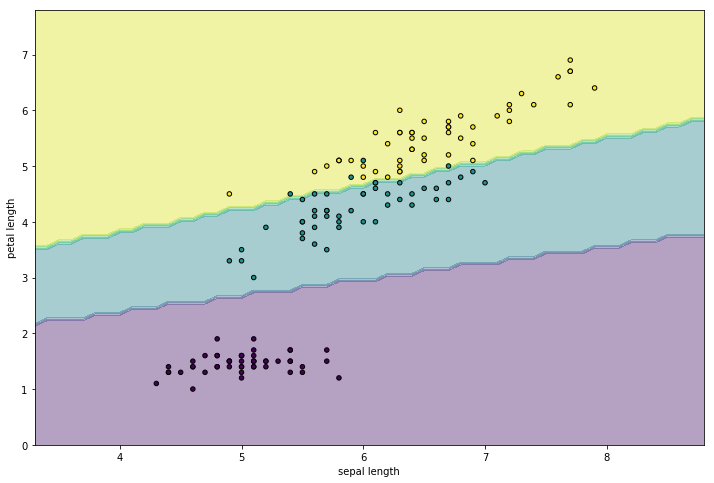

In [122]:
%matplotlib inline
import matplotlib.pyplot as plt
dt = data.data[:,[0,2]]
x_min, x_max = dt[:, 0].min() - 1, dt[:, 0].max() + 1
y_min, y_max = dt[:, 1].min() - 1, dt[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# here "model" is your model's prediction (classification) function
Z = model.predict(np.c_[xx.ravel(), yy.ravel()].T) 

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Z,alpha=0.4)
#plt.axis('off')
plt.scatter(dt[:, 0], dt[:, 1], c=y,s=20, edgecolor='k')
plt.xlabel('sepal length')
plt.ylabel('petal length')

#### Optimization using adam

In [128]:
model = DNNClassifier(layer_dims=[X.shape[0], 6, 4, 3],hidden_layers=[('relu',0),('relu',0.001),'softmax'],
                      optimization_method='ADAM',tolarance=None,max_epoch=900,verbose=1,seed=15)
model.fit(X,Y)

Initilizing Weights...
Starting Training...
Cost after iteration 100: 0.2410524910881379
Cost after iteration 200: 0.156933182530525
Cost after iteration 300: 0.4761735247293429
Cost after iteration 400: 0.07214152730963741
Cost after iteration 500: 0.05967539457093406
Cost after iteration 600: 0.18715592303547562
Cost after iteration 700: 0.14981032092268548
Cost after iteration 800: 0.0827908281308122
Cost after iteration 900: 0.036099842961624516
Cost after iteration 1000: 0.11922918395829907
Cost after iteration 1100: 0.06045911527459521
Cost after iteration 1200: 0.16172553441807452
Cost after iteration 1300: 0.06256067453485452
Cost after iteration 1400: 0.12874850080531294
Cost after iteration 1500: 0.07305011781964871
Cost after iteration 1600: 0.06243921009966007
Cost after iteration 1700: 0.08108399200652769
Cost after iteration 1800: 0.03237463795372483
Cost after iteration 1900: 0.11286957459033613
Cost after iteration 2000: 0.027619164456255337
Cost after iteration 2100: 0

In [129]:
y_pred = model.predict(X,proba=False)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Text(0.5,1,'Decision Boundaries')

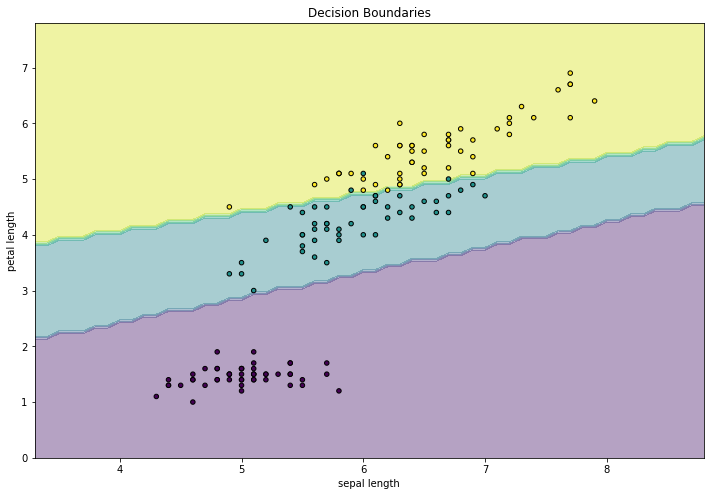

In [130]:
### Decision Boundaries
%matplotlib inline
import matplotlib.pyplot as plt
dt = data.data[:,[0,2]]
x_min, x_max = dt[:, 0].min() - 1, dt[:, 0].max() + 1
y_min, y_max = dt[:, 1].min() - 1, dt[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# here "model" is your model's prediction (classification) function
Z = model.predict(np.c_[xx.ravel(), yy.ravel()].T) 

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Z,alpha=0.4)
#plt.axis('off')
plt.scatter(dt[:, 0], dt[:, 1], c=y,s=20, edgecolor='k')
plt.xlabel('sepal length')
plt.ylabel('petal length')
plt.title('Decision Boundaries')

#### Moon Curves:

In [161]:
from sklearn.datasets import make_moons

In [190]:
x,y =make_moons(n_samples=1500, noise=.05)
X = x.T
lb = preprocessing.LabelBinarizer()
Y = lb.fit_transform(y)
y_next = np.where(y==0,1,0)
Y = Y.T
Y = list(Y)
Y.append(y_next)
Y = np.array(Y)

In [192]:
Y.shape

(2, 1500)

In [204]:
model = DNNClassifier(layer_dims=[X.shape[0], 6, 4,3, 2],hidden_layers=[('relu',0),('relu',0.001),'sigmoid','softmax'],
                      optimization_method='ADAM',tolarance=None,batch_size=512,max_epoch=700,verbose=1,seed=25)
model.fit(X,Y)

Initilizing Weights...
Starting Training...
Cost after iteration 100: 0.3621104058351161
Cost after iteration 200: 0.12213695696079738
Cost after iteration 300: 0.03338506361379205
Cost after iteration 400: 0.014662242229828303
Cost after iteration 500: 0.007697555099209768
Cost after iteration 600: 0.0046203951192425935
Cost after iteration 700: 0.0030145995218986876
Cost after iteration 800: 0.0021057294721802894
Cost after iteration 900: 0.0015219705690779476
Cost after iteration 1000: 0.0011528026448003074
Cost after iteration 1100: 0.0008815357076611342
Cost after iteration 1200: 0.0007046679789013923
Cost after iteration 1300: 0.0005789409917109167
Cost after iteration 1400: 0.00046502519675507885
Cost after iteration 1500: 0.00039321669343281377
Cost after iteration 1600: 0.0003289936748258177
Cost after iteration 1700: 0.00028169521217718727
Cost after iteration 1800: 0.00023916938949804847
Cost after iteration 1900: 0.00020995242501015122
Cost after iteration 2000: 0.000182376

In [205]:
model.predict(X)

array([0, 1, 0, ..., 1, 1, 0])

Text(0.5,1,'Decision Boundaries')

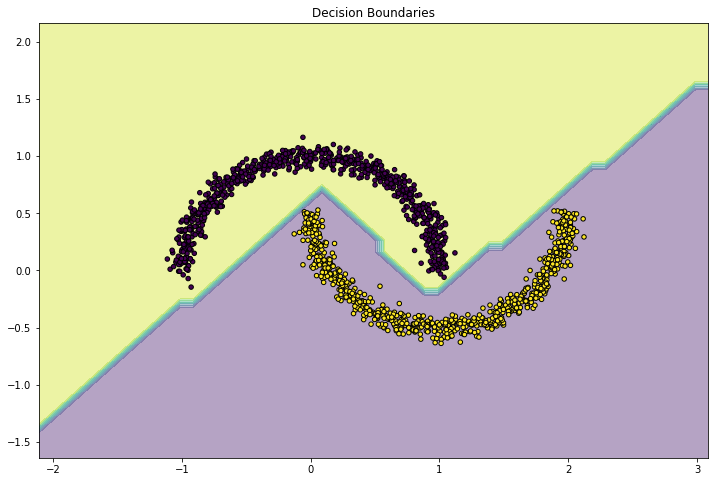

In [207]:
### Decision Boundaries
%matplotlib inline
import matplotlib.pyplot as plt
dt = x
x_min, x_max = dt[:, 0].min() - 1, dt[:, 0].max() + 1
y_min, y_max = dt[:, 1].min() - 1, dt[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# here "model" is your model's prediction (classification) function
Z = model.predict(np.c_[xx.ravel(), yy.ravel()].T) 

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Z,alpha=0.4)
#plt.axis('off')
plt.scatter(dt[:, 0], dt[:, 1], c=y,s=20, edgecolor='k')
plt.title('Decision Boundaries')

#### Some Noise data

In [208]:
from sklearn.datasets import make_moons, make_circles, make_classification

In [219]:
x,y = make_circles(n_samples=1500,noise=0.25, factor=0.5, random_state=1)

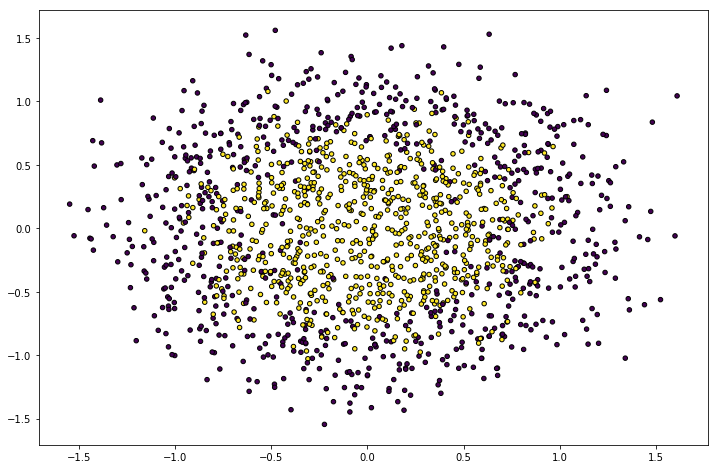

In [220]:
plt.figure(figsize=(12,8))
plt.scatter(x[:, 0], x[:, 1], c=y,s=20, edgecolor='k')

In [221]:
X = x.T
lb = preprocessing.LabelBinarizer()
Y = lb.fit_transform(y)
y_next = np.where(y==0,1,0)
Y = Y.T
Y = list(Y)
Y.append(y_next)
Y = np.array(Y)

In [226]:
model = DNNClassifier(layer_dims=[X.shape[0], 6, 4,3, 2],hidden_layers=[('relu',0),('relu',0.001),'sigmoid','softmax'],
                      optimization_method='ADAM',tolarance=None,batch_size=512,max_epoch=700,verbose=1,seed=25)
model.fit(X,Y)

Initilizing Weights...
Starting Training...
Cost after iteration 100: 0.45720467395194553
Cost after iteration 200: 0.405379316535335
Cost after iteration 300: 0.3869594502913372
Cost after iteration 400: 0.3772658512063516
Cost after iteration 500: 0.3779936532090616
Cost after iteration 600: 0.31271739773971713
Cost after iteration 700: 0.3426347841044403
Cost after iteration 800: 0.3915129531097433
Cost after iteration 900: 0.3555932346136275
Cost after iteration 1000: 0.3835513814261377
Cost after iteration 1100: 0.3572449192481134
Cost after iteration 1200: 0.34773344818683366
Cost after iteration 1300: 0.3427315993713393
Cost after iteration 1400: 0.35526492617368904
Cost after iteration 1500: 0.3427916397480477
Cost after iteration 1600: 0.38698530968706796
Cost after iteration 1700: 0.34460680291127704
Cost after iteration 1800: 0.3281842154819242
Cost after iteration 1900: 0.362553112032135
Cost after iteration 2000: 0.37608659798233757
Cost after iteration 2100: 0.32291330367

Text(0.5,1,'Decision Boundaries')

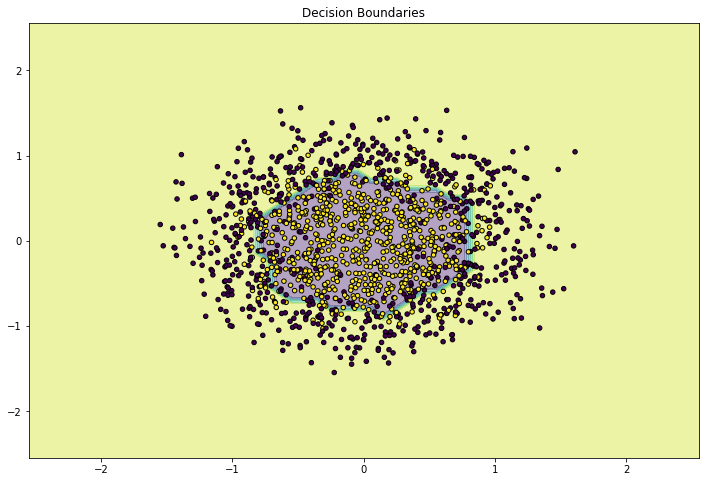

In [227]:
### Decision Boundaries
%matplotlib inline
import matplotlib.pyplot as plt
dt = x
x_min, x_max = dt[:, 0].min() - 1, dt[:, 0].max() + 1
y_min, y_max = dt[:, 1].min() - 1, dt[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# here "model" is your model's prediction (classification) function
Z = model.predict(np.c_[xx.ravel(), yy.ravel()].T) 

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Z,alpha=0.4)
#plt.axis('off')
plt.scatter(dt[:, 0], dt[:, 1], c=y,s=20, edgecolor='k')
plt.title('Decision Boundaries')

In [235]:
model = DNNClassifier(layer_dims=[X.shape[0], 6, 5,4, 2],hidden_layers=[('relu',0),('relu',0.001),'sigmoid','softmax'],
                      optimization_method='ADAM',keep_proba=0.85,tolarance=None,batch_size=512,max_epoch=1000,verbose=1,seed=15)
model.fit(X,Y)

Initilizing Weights...
Starting Training...
Cost after iteration 100: 0.788188134256454
Cost after iteration 200: 0.7019137303780809
Cost after iteration 300: 0.6898942771688221
Cost after iteration 400: 0.6783332381538787
Cost after iteration 500: 0.6817545656079715
Cost after iteration 600: 0.6771002236671971
Cost after iteration 700: 0.5683667278910918
Cost after iteration 800: 0.5125143762758825
Cost after iteration 900: 0.5220465692907031
Cost after iteration 1000: 0.5063157270635141
Cost after iteration 1100: 0.4360049590512598
Cost after iteration 1200: 0.48342245988515187
Cost after iteration 1300: 0.47680778908862786
Cost after iteration 1400: 0.4821902764632856
Cost after iteration 1500: 0.4993909442888387
Cost after iteration 1600: 0.5031331698286605
Cost after iteration 1700: 0.41235219429375114
Cost after iteration 1800: 0.4409391440104965
Cost after iteration 1900: 0.4897770330836313
Cost after iteration 2000: 0.44360422325161886
Cost after iteration 2100: 0.4279769330913

Text(0.5,1,'Decision Boundaries with dropout')

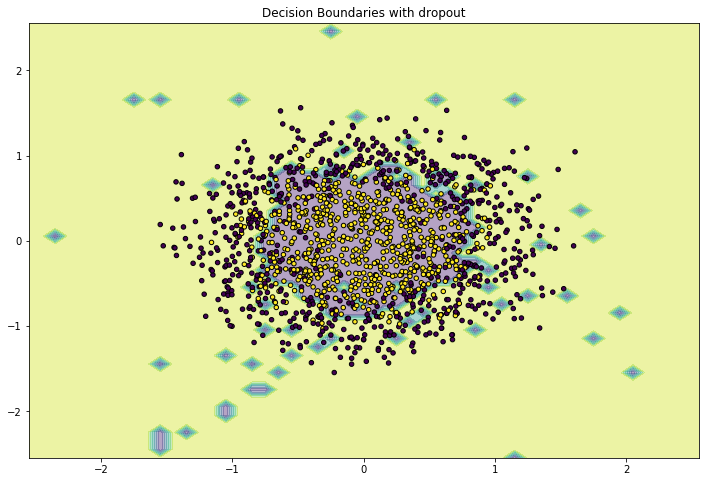

In [236]:
### Decision Boundaries
%matplotlib inline
import matplotlib.pyplot as plt
dt = x
x_min, x_max = dt[:, 0].min() - 1, dt[:, 0].max() + 1
y_min, y_max = dt[:, 1].min() - 1, dt[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# here "model" is your model's prediction (classification) function
Z = model.predict(np.c_[xx.ravel(), yy.ravel()].T) 

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Z,alpha=0.4)
#plt.axis('off')
plt.scatter(dt[:, 0], dt[:, 1], c=y,s=20, edgecolor='k')
plt.title('Decision Boundaries with dropout')

#### With l2 regularization:

With small lambda

In [251]:
model = DNNClassifier(layer_dims=[X.shape[0], 6, 4,3, 2],hidden_layers=[('relu',0),('relu',0.001),'sigmoid','softmax'],
                      optimization_method='ADAM',penality='l2',lamda=0.35,
                      tolarance=None,batch_size=512,max_epoch=1000,verbose=1,seed=25)
model.fit(X,Y)

Initilizing Weights...
Starting Training...
Cost after iteration 100: 0.5806166689724982
Cost after iteration 200: 0.45974908548940446
Cost after iteration 300: 0.4352750468782838
Cost after iteration 400: 0.4100871900132933
Cost after iteration 500: 0.4072215489720923
Cost after iteration 600: 0.3474795736890927
Cost after iteration 700: 0.38918413031656
Cost after iteration 800: 0.3954144399690004
Cost after iteration 900: 0.37744517763552976
Cost after iteration 1000: 0.4106163947286747
Cost after iteration 1100: 0.3949461838404195
Cost after iteration 1200: 0.3607784478023016
Cost after iteration 1300: 0.35741376846518674
Cost after iteration 1400: 0.35755798049644594
Cost after iteration 1500: 0.37328545889459613
Cost after iteration 1600: 0.3983437120495418
Cost after iteration 1700: 0.3776207638259863
Cost after iteration 1800: 0.34347732425351896
Cost after iteration 1900: 0.38361435332967153
Cost after iteration 2000: 0.39826276937478966
Cost after iteration 2100: 0.3427333882

Text(0.5,1,'Decision Boundaries with l2 reg')

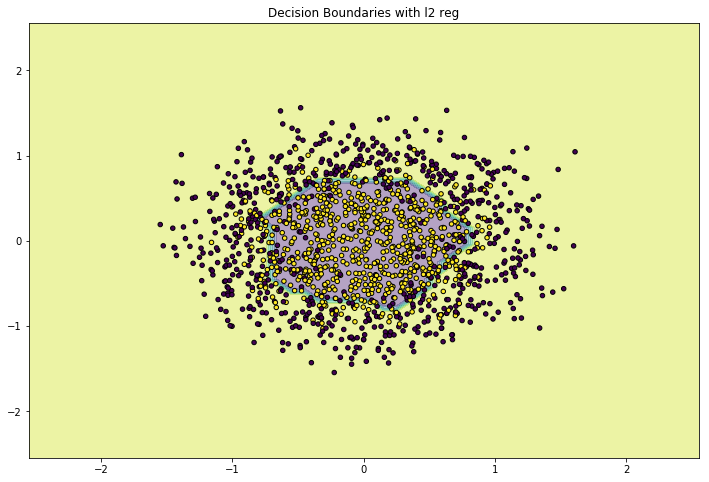

In [252]:
### Decision Boundaries
%matplotlib inline
import matplotlib.pyplot as plt
dt = x
x_min, x_max = dt[:, 0].min() - 1, dt[:, 0].max() + 1
y_min, y_max = dt[:, 1].min() - 1, dt[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# here "model" is your model's prediction (classification) function
Z = model.predict(np.c_[xx.ravel(), yy.ravel()].T) 

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Z,alpha=0.4)
#plt.axis('off')
plt.scatter(dt[:, 0], dt[:, 1], c=y,s=20, edgecolor='k')
plt.title('Decision Boundaries with l2 reg')

With High lambda

In [255]:
model = DNNClassifier(layer_dims=[X.shape[0], 6, 4,3, 2],hidden_layers=[('relu',0),('relu',0.001),'sigmoid','softmax'],
                      optimization_method='ADAM',penality='l2',lamda=3,
                      tolarance=None,batch_size=512,max_epoch=1000,verbose=1,seed=25)
model.fit(X,Y)

Initilizing Weights...
Starting Training...
Cost after iteration 100: 0.7036416575379517
Cost after iteration 200: 0.6902162747614012
Cost after iteration 300: 0.6671797152597352
Cost after iteration 400: 0.6365139075412387
Cost after iteration 500: 0.6099057595332051
Cost after iteration 600: 0.6121004325210112
Cost after iteration 700: 0.5933699400088326
Cost after iteration 800: 0.6234754556784149
Cost after iteration 900: 0.5865937347819079
Cost after iteration 1000: 0.6296352093897949
Cost after iteration 1100: 0.6073494260910217
Cost after iteration 1200: 0.5745560242945857
Cost after iteration 1300: 0.6085452377640669
Cost after iteration 1400: 0.5760010281668105
Cost after iteration 1500: 0.5864934730892997
Cost after iteration 1600: 0.6011090834059049
Cost after iteration 1700: 0.6142769590843096
Cost after iteration 1800: 0.6154664076402668
Cost after iteration 1900: 0.5884989759002314
Cost after iteration 2000: 0.6200659142833614
Cost after iteration 2100: 0.587044090638867


Text(0.5,1,'Decision Boundaries with l2 reg')

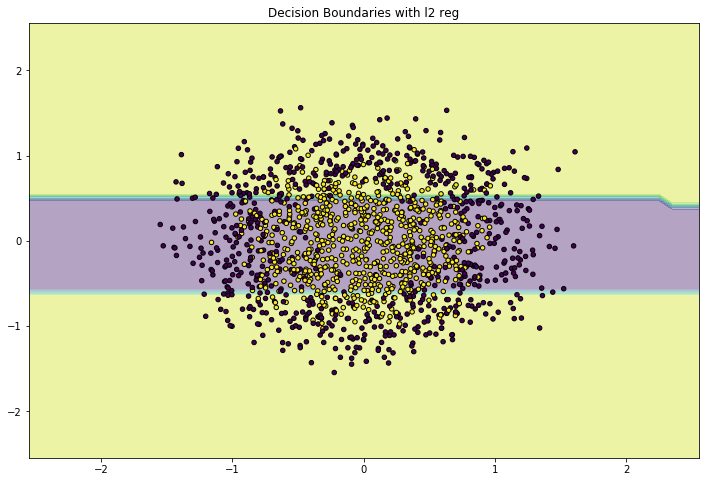

In [256]:
### Decision Boundaries
%matplotlib inline
import matplotlib.pyplot as plt
dt = x
x_min, x_max = dt[:, 0].min() - 1, dt[:, 0].max() + 1
y_min, y_max = dt[:, 1].min() - 1, dt[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# here "model" is your model's prediction (classification) function
Z = model.predict(np.c_[xx.ravel(), yy.ravel()].T) 

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Z,alpha=0.4)
#plt.axis('off')
plt.scatter(dt[:, 0], dt[:, 1], c=y,s=20, edgecolor='k')
plt.title('Decision Boundaries with l2 reg')

#### With L1 Regularization

With Low Lambda

In [259]:
model = DNNClassifier(layer_dims=[X.shape[0], 6, 4,3, 2],hidden_layers=[('relu',0),('relu',0.001),'sigmoid','softmax'],
                      optimization_method='ADAM',penality='l1',lamda=0.4,
                      tolarance=None,batch_size=512,max_epoch=1000,verbose=1,seed=25)
model.fit(X,Y)

Initilizing Weights...
Starting Training...
Cost after iteration 100: 0.5225446366680638
Cost after iteration 200: 0.4099718597190881
Cost after iteration 300: 0.4049840523488595
Cost after iteration 400: 0.3835680407577898
Cost after iteration 500: 0.38942437251658774
Cost after iteration 600: 0.3332954592810706
Cost after iteration 700: 0.3596084492732947
Cost after iteration 800: 0.3735684884413414
Cost after iteration 900: 0.3648458498978709
Cost after iteration 1000: 0.4008201838393185
Cost after iteration 1100: 0.35608614726068316
Cost after iteration 1200: 0.3575552859331963
Cost after iteration 1300: 0.3535500848097046
Cost after iteration 1400: 0.3603667514893773
Cost after iteration 1500: 0.3632277006835128
Cost after iteration 1600: 0.4052922377488472
Cost after iteration 1700: 0.3645443690074442
Cost after iteration 1800: 0.34379414468741054
Cost after iteration 1900: 0.38598583710609363
Cost after iteration 2000: 0.393730363195893
Cost after iteration 2100: 0.3380342528033

Text(0.5,1,'Decision Boundaries with l1 reg')

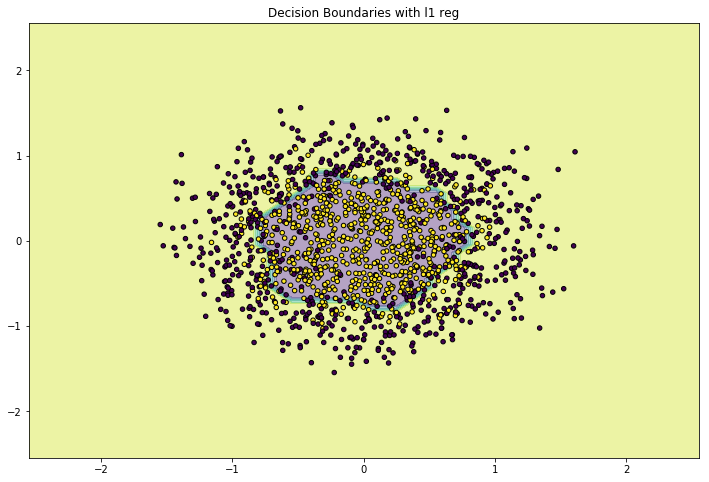

In [261]:
### Decision Boundaries
%matplotlib inline
import matplotlib.pyplot as plt
dt = x
x_min, x_max = dt[:, 0].min() - 1, dt[:, 0].max() + 1
y_min, y_max = dt[:, 1].min() - 1, dt[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# here "model" is your model's prediction (classification) function
Z = model.predict(np.c_[xx.ravel(), yy.ravel()].T) 

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Z,alpha=0.4)
#plt.axis('off')
plt.scatter(dt[:, 0], dt[:, 1], c=y,s=20, edgecolor='k')
plt.title('Decision Boundaries with l1 reg')

With High Lambda

In [266]:
model = DNNClassifier(layer_dims=[X.shape[0], 6, 4,3, 2],hidden_layers=[('relu',0),('relu',0.001),'sigmoid','softmax'],
                      optimization_method='ADAM',penality='l1',lamda=3.5,
                      tolarance=None,batch_size=512,max_epoch=1000,verbose=1,seed=15)
model.fit(X,Y)

Initilizing Weights...
Starting Training...
Cost after iteration 100: 0.6947741144756275
Cost after iteration 200: 0.6865100179447006
Cost after iteration 300: 0.6808774991172852
Cost after iteration 400: 0.6759591840050962
Cost after iteration 500: 0.6711090270403037
Cost after iteration 600: 0.6641226487315927
Cost after iteration 700: 0.6670957848437121
Cost after iteration 800: 0.6674261910405109
Cost after iteration 900: 0.6459777825521165
Cost after iteration 1000: 0.652011044063832
Cost after iteration 1100: 0.6552505487826152
Cost after iteration 1200: 0.6573969102569003
Cost after iteration 1300: 0.6702285365506423
Cost after iteration 1400: 0.6707962869430603
Cost after iteration 1500: 0.6625238585966345
Cost after iteration 1600: 0.6533984172565822
Cost after iteration 1700: 0.6744558831868294
Cost after iteration 1800: 0.6673310796279402
Cost after iteration 1900: 0.6621421246292215
Cost after iteration 2000: 0.6719771410552794
Cost after iteration 2100: 0.6725542786587769


Text(0.5,1,'Decision Boundaries with l1 reg')

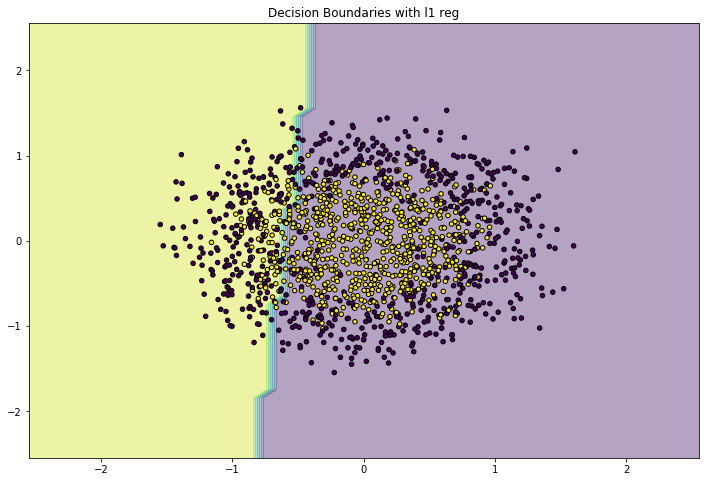

In [267]:
### Decision Boundaries
%matplotlib inline
import matplotlib.pyplot as plt
dt = x
x_min, x_max = dt[:, 0].min() - 1, dt[:, 0].max() + 1
y_min, y_max = dt[:, 1].min() - 1, dt[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# here "model" is your model's prediction (classification) function
Z = model.predict(np.c_[xx.ravel(), yy.ravel()].T) 

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Z,alpha=0.4)
#plt.axis('off')
plt.scatter(dt[:, 0], dt[:, 1], c=y,s=20, edgecolor='k')
plt.title('Decision Boundaries with l1 reg')

References:
1. Deeplearning.ai Course
2. Forward Propagation
       - https://www.youtube.com/watch?v=a8i2eJin0lY&index=38&list=PLkDaE6sCZn6Ec-XTbcX1uRg2_u4xOEky0
3. Back Prop
       - https://www.youtube.com/watch?v=yXcQ4B-YSjQ&index=34&list=PLkDaE6sCZn6Ec-XTbcX1uRg2_u4xOEky0
4. Dropout
       - https://www.youtube.com/watch?v=D8PJAL-MZv8&index=6&list=PLkDaE6sCZn6Hn0vK8co82zjQtt3T2Nkqc
5. Appliedaicourse